In [ ]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=b251516a825a1163203a5e149490e27b1f326df0d1ac64f86b305a8224240873
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings
import geopandas as gpd
import tensorflow as tf
import plotly.graph_objects as go
from nltk.corpus import stopwords

from sklearn.utils import resample
import torch

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

In [ ]:
path = "/content/drive/MyDrive/tubitak/datasets/preprocessed_final1.csv"
df = pd.read_csv(path)

In [ ]:
scaler = MinMaxScaler()
scaling_columns = ['Temperature(F)', 'Distance(mi)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                   'Wind_Speed(mph)', 'Precipitation(in)', 'Start_Lng', 'Start_Lat',
                   'Month', 'Weekday', 'Day','Hour','KDE','Population']

scaling_columns = [col for col in scaling_columns if col in df.columns]

df[scaling_columns] = scaler.fit_transform(df[scaling_columns])

print("Feature scaling completed.")
df.head()

del scaling_columns

Feature scaling completed.


In [ ]:
categorical_features = set([ "Weather_Condition"])

for cat in categorical_features:
    df[cat] = df[cat].astype("category")

print("Unique classes for each categorical feature:")
for cat in categorical_features:
    print("{:15s}".format(cat), "\t", len(df[cat].unique()))


Unique classes for each categorical feature:
Weather_Condition 	 12


In [ ]:
# Encode Weather_Condition with one-hot encoding
df = pd.get_dummies(df, columns=['Weather_Condition'], prefix='Weather', drop_first=True)
print("Weather_Condition encoded with one-hot encoding.")

del categorical_features

Weather_Condition encoded with one-hot encoding.


In [ ]:
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)

del bool_columns

df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Population,...,Weather_Cloudy,Weather_Fog,Weather_Hail,Weather_Rain,Weather_Sand,Weather_Smoke,Weather_Snow,Weather_Thunderstorm,Weather_Tornado,Weather_Windy
0,3,0.626257,0.705349,0.000023,0.425338,0.909091,0.506057,0.071030,0.006440,0.284194,...,0,0,0,1,0,0,0,0,0,0
1,2,0.628830,0.726694,0.000023,0.428716,1.000000,0.505545,0.071030,0.006440,0.284194,...,0,0,0,1,0,0,0,0,0,0
2,2,0.593452,0.705803,0.000023,0.422297,1.000000,0.505886,0.071030,0.003220,0.284194,...,1,0,0,0,0,0,0,0,0,0
3,3,0.621455,0.702796,0.000023,0.419257,0.959596,0.505375,0.063885,0.004232,0.284194,...,1,0,0,0,0,0,0,0,0,0
4,2,0.616547,0.703095,0.000023,0.422297,0.888889,0.505545,0.042447,0.003220,0.284194,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
severity_counts = df['Severity'].value_counts()
print("Before balancing:")
print(severity_counts)

Before balancing:
Severity
2    5098823
3    1282598
4     178324
1      63030
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X_features = df.drop(columns=['Severity'])
y_target = df['Severity']

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_features, y_target)

In [ ]:
resampled_data = pd.DataFrame(X_resampled, columns=X_features.columns)
resampled_data['Severity'] = y_resampled  # Hedef değişkeni ekle

# CSV dosyasına kaydet
resampled_data.to_csv('smote_resampled_data.csv', index=False)
print("Resampled data saved to 'smote_resampled_data.csv'")

Resampled data saved to 'smote_resampled_data.csv'


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
class RandomForestModel:
    def __init__(self, n_estimators=100, random_state=42):
        """
        Random Forest Model initialization.
        Random Forest modeli başlatılır.
        """
        self.model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        self.is_trained = False  # Modelin eğitildiğini kontrol etmek için

    def train(self, X, y, test_size=0.2):
        """
        Train the Random Forest model.
        Random Forest modelini eğitir.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        self.model.fit(self.X_train, self.y_train)
        self.is_trained = True
        print("Model trained successfully!")

    def evaluate(self):
        """
        Evaluate the model on the test set.
        Test veri kümesinde modeli değerlendirir.
        """
        if not self.is_trained:
            raise Exception("Model is not trained. Please train the model first.")

        y_pred = self.model.predict(self.X_test)
        print("Accuracy:", accuracy_score(self.y_test, y_pred))
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

    def predict(self, X):
        """
        Make predictions using the trained model.
        Eğitilmiş model ile tahminler yapar.
        """
        if not self.is_trained:
            raise Exception("Model is not trained. Please train the model first.")

        return self.model.predict(X)

    def feature_importances(self, feature_names):
        """
        Get feature importance values.
        Özelliklerin önem derecelerini döndürür.
        """
        if not self.is_trained:
            raise Exception("Model is not trained. Please train the model first.")

        importances = self.model.feature_importances_
        return {feature: importance for feature, importance in zip(feature_names, importances)}

In [ ]:
rf_model = RandomForestModel(n_estimators=100, random_state=42)

In [ ]:
rf_model.train(X_resampled, y_resampled)

Model trained successfully!


In [18]:
rf_model.evaluate()

Accuracy: 0.944809329798858

Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99   1020027
           2       0.94      0.88      0.91   1020250
           3       0.91      0.91      0.91   1020076
           4       0.95      0.98      0.96   1018706

    accuracy                           0.94   4079059
   macro avg       0.94      0.94      0.94   4079059
weighted avg       0.94      0.94      0.94   4079059



In [19]:
from joblib import dump, load

In [21]:
dump(rf_model, '/content/drive/MyDrive/tubitak/models/rfmodel.joblib')

['/content/drive/MyDrive/tubitak/models/rfmodel.joblib']

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

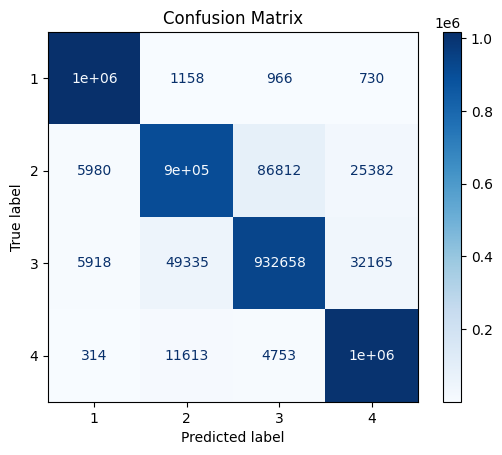

In [23]:
y_pred = rf_model.model.predict(rf_model.X_test)
cm = confusion_matrix(rf_model.y_test, y_pred)

# Görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
y_pred_proba = rf_model.model.predict_proba(rf_model.X_test)

# ROC Eğrisi (Her sınıf için)
plt.figure(figsize=(8, 6))
for i in range(y_pred_proba.shape[1]):
    fpr, tpr, _ = roc_curve(rf_model.y_test == i + 1, y_pred_proba[:, i])
    auc = roc_auc_score(rf_model.y_test == i + 1, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i + 1} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()